In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid

import shap

/home/campus.ncl.ac.uk/c1014695/miniconda3/envs/pytorch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Model

In [33]:
batch_size = 64
num_epochs = 25
device = torch.device("cpu")
num_dimensions = 40

loss_fn = nn.BCELoss()

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(num_dimensions, 100),
            nn.ReLU(),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x


In [34]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.unsqueeze(1).float().to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = (output > 0.5).float()  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )

## Dataset

In [5]:
mnist_trainset = datasets.MNIST(
    "Dataset",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

mnist_testset = datasets.MNIST(
    "Dataset",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

classes = [0,1]


train_indices = [i for i, label in enumerate(mnist_trainset.targets) if label in classes]
test_indices = [i for i, label in enumerate(mnist_testset.targets) if label in classes]

train_subset = Subset(mnist_trainset, train_indices)
test_subset = Subset(mnist_testset, test_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False
)

### Autoencoder

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        # Encoding from 784 (32*32) to an arbitary number of features
        self.encoder = nn.Linear(784, encoding_dim)
        # Encoding to 784 (32*32) to an arbitary number of features
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x

In [21]:
encoder_epochs = 100

encoder = AutoEncoder(num_dimensions).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters())

In [22]:
def train_autoencoder(epoch):
    train_loss = 0.0

    for data in train_loader:
        images, _ = data

        images = images.view(images.size(0), -1)
        images = images.to(device)

        optimizer.zero_grad()

        outputs = encoder(images)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

# Run the training and testing for defined epochs
for epoch in range(encoder_epochs):
    train_autoencoder(epoch)

Epoch: 0 	Training Loss: 2.879808
Epoch: 1 	Training Loss: 1.478115
Epoch: 2 	Training Loss: 1.239759
Epoch: 3 	Training Loss: 1.090258
Epoch: 4 	Training Loss: 0.988044
Epoch: 5 	Training Loss: 0.905617
Epoch: 6 	Training Loss: 0.865954
Epoch: 7 	Training Loss: 0.838533
Epoch: 8 	Training Loss: 0.818260
Epoch: 9 	Training Loss: 0.804783
Epoch: 10 	Training Loss: 0.780746
Epoch: 11 	Training Loss: 0.768091
Epoch: 12 	Training Loss: 0.761468
Epoch: 13 	Training Loss: 0.757854
Epoch: 14 	Training Loss: 0.754960
Epoch: 15 	Training Loss: 0.752933
Epoch: 16 	Training Loss: 0.752189
Epoch: 17 	Training Loss: 0.750837
Epoch: 18 	Training Loss: 0.750009
Epoch: 19 	Training Loss: 0.749564
Epoch: 20 	Training Loss: 0.749055
Epoch: 21 	Training Loss: 0.747725
Epoch: 22 	Training Loss: 0.747556
Epoch: 23 	Training Loss: 0.748013
Epoch: 24 	Training Loss: 0.747589
Epoch: 25 	Training Loss: 0.746662
Epoch: 26 	Training Loss: 0.746173
Epoch: 27 	Training Loss: 0.746620
Epoch: 28 	Training Loss: 0.74

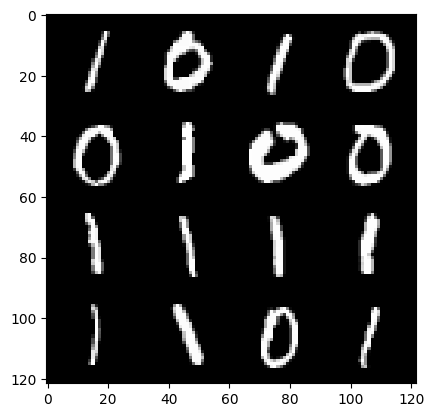

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30662638..1.3247821].


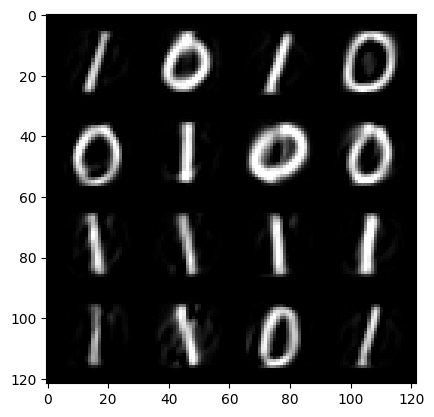

In [23]:
from torchvision.utils import make_grid


def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=encoder(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

In [24]:
def encode_dataset():
    encoder.eval()
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    with torch.no_grad():
      for data, label in train_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          train_features.append(encoded.to('cpu'))
          train_labels.append(label)

      for data, label in test_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          test_features.append(encoded.to('cpu'))
          test_labels.append(label)

    return torch.cat(train_features, dim=0), torch.cat(test_features, dim=0), torch.cat(train_labels, dim=0), torch.cat(test_labels, dim=0)

features_to_train, features_to_test, labels_to_train, labels_to_test = encode_dataset()

In [25]:
train_dataset = torch.utils.data.TensorDataset(features_to_train, labels_to_train)
test_dataset = torch.utils.data.TensorDataset(features_to_test, labels_to_test)

In [26]:
encoded_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
encoded_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
encoded_testloader.dataset.tensors[1].shape

torch.Size([2115])

## Train

In [35]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, encoded_trainloader, optimizer, epoch)
    test(model, device, encoded_testloader)

Train Epoch: 1 [0/12665 (0%)]	Loss: 0.698135
Train Epoch: 1 [3200/12665 (25%)]	Loss: 0.693687
Train Epoch: 1 [6400/12665 (51%)]	Loss: 0.686335
Train Epoch: 1 [9600/12665 (76%)]	Loss: 0.684790

Test set: Average loss: 0.0110, Accuracy: 1135/2115 (54%)

Train Epoch: 2 [0/12665 (0%)]	Loss: 0.673413
Train Epoch: 2 [3200/12665 (25%)]	Loss: 0.690688
Train Epoch: 2 [6400/12665 (51%)]	Loss: 0.680170
Train Epoch: 2 [9600/12665 (76%)]	Loss: 0.674611

Test set: Average loss: 0.0107, Accuracy: 1340/2115 (63%)

Train Epoch: 3 [0/12665 (0%)]	Loss: 0.651819
Train Epoch: 3 [3200/12665 (25%)]	Loss: 0.670518
Train Epoch: 3 [6400/12665 (51%)]	Loss: 0.636406
Train Epoch: 3 [9600/12665 (76%)]	Loss: 0.609113

Test set: Average loss: 0.0081, Accuracy: 2073/2115 (98%)

Train Epoch: 4 [0/12665 (0%)]	Loss: 0.544147
Train Epoch: 4 [3200/12665 (25%)]	Loss: 0.391277
Train Epoch: 4 [6400/12665 (51%)]	Loss: 0.309925
Train Epoch: 4 [9600/12665 (76%)]	Loss: 0.177607

Test set: Average loss: 0.0017, Accuracy: 2104/2115

## SHAP

In [36]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(encoded_testloader))
images, _ = batch

background = images[:61]
test_images = images[61:64]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [42]:
features_to_train.shape

torch.Size([12665, 40])

In [57]:
shap_values_train = e.shap_values(features_to_train).reshape((12665, 40))
shap_values_test = e.shap_values(features_to_test).reshape((2115, 40))

In [59]:
print(shap_values_train.shape)
print(shap_values_test.shape)

(12665, 40)
(2115, 40)


In [77]:
shap_values = np.concatenate((shap_values_train, shap_values_test), axis=0)
labels = np.concatenate((labels_to_train, labels_to_test), axis=0)

In [82]:
columns = [f'feature_{x}' for x in range(0,num_dimensions)]

shap_values_df = pd.DataFrame(shap_values, columns=columns)
labels_df = pd.DataFrame(labels, columns=['class'])

shap_values_df = shap_values_df.join(labels_df)
shap_values_df.to_csv('Data/shap_values.csv', index=None)

In [83]:
shap_values_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,class
0,-0.031753,0.013053,0.024478,0.001174,-0.001167,0.005035,0.000880,0.004072,0.041919,-0.000039,...,-0.000248,0.031375,0.000197,-0.001640,0.013400,0.036643,-0.001699,-0.020981,0.000695,1
1,-0.034784,0.010834,0.022339,0.001556,-0.001053,0.002900,0.000794,0.003893,0.044079,-0.000831,...,-0.000225,0.029360,0.000128,-0.001135,0.041457,0.022445,-0.003710,-0.012260,0.000129,1
2,0.009514,0.008650,0.023106,0.000131,-0.002008,0.004954,0.000742,0.002986,0.010825,-0.002349,...,-0.000013,0.021614,0.000079,-0.001141,-0.008246,0.027803,0.001497,0.000651,0.000832,1
3,-0.044787,-0.025612,-0.027221,-0.000417,0.000588,-0.015421,0.000553,-0.009979,-0.017730,0.002964,...,0.000257,-0.044368,-0.000721,0.004021,0.021060,-0.077596,0.000862,-0.020705,-0.003887,0
4,-0.032916,0.012221,0.031982,0.001234,-0.000976,0.006967,0.000820,0.004327,0.034942,-0.000614,...,-0.000147,0.032910,0.000261,-0.001966,0.009664,0.042835,-0.006094,-0.025573,0.001521,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14775,-0.015308,0.009033,0.032943,0.000706,-0.001843,0.003437,0.000136,0.002322,-0.002389,-0.000127,...,0.000221,0.025544,0.000659,-0.001443,0.055069,0.047270,0.002239,0.013217,0.001049,1
14776,-0.027100,-0.026119,-0.044836,-0.003861,0.004564,-0.018750,0.000011,-0.008456,-0.006640,-0.001379,...,-0.000079,-0.048593,-0.002188,0.004230,0.036473,-0.083248,0.008193,0.046005,-0.006454,0
14777,0.018033,0.009043,0.029670,0.000080,-0.002122,0.005445,0.000648,0.002298,0.005126,-0.002658,...,-0.000044,0.023569,0.000129,-0.001224,-0.003276,0.028634,0.002542,-0.002378,0.000671,1
14778,-0.023770,-0.040283,-0.062094,-0.003422,0.006807,-0.030179,-0.000524,-0.008933,0.010551,-0.010786,...,0.000567,-0.068636,-0.001602,0.009189,0.078476,-0.169725,0.012518,0.049725,-0.012465,0


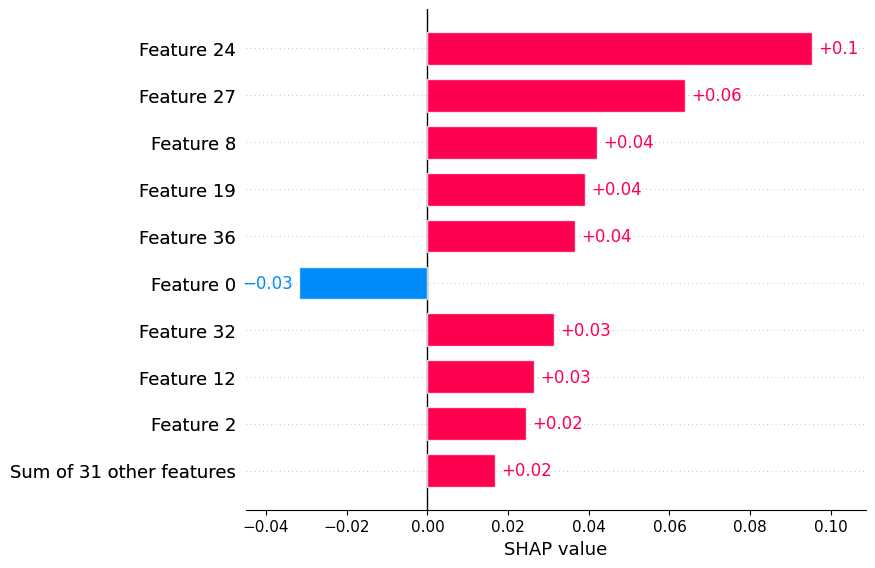

In [68]:
shap.plots.bar(shap.Explanation(shap_values_train[0]))

In [72]:
from sklearn.manifold import TSNE

shap_values_2d = TSNE(n_components=2, random_state=0, metric='cosine').fit_transform(shap_values)

In [87]:
shap_values_2d_df = pd.DataFrame(shap_values_2d, columns=['x','y']).join(labels_df)
shap_values_2d_df.to_csv('Data/shap_values_2d.csv', index=None)

In [92]:
shap_values_2d_df.describe()

,x,y,class
count,14780.000000,14780.000000,14780.00000
mean,-0.432312,0.036781,0.53295
std,43.542702,38.151485,0.49893
min,-88.225700,-82.973785,0.00000
25%,-38.358378,-29.191990,0.00000
50%,2.117879,-0.231633,1.00000
75%,35.864428,29.868630,1.00000
max,79.154770,83.322220,1.00000


<Axes: xlabel='x', ylabel='y'>

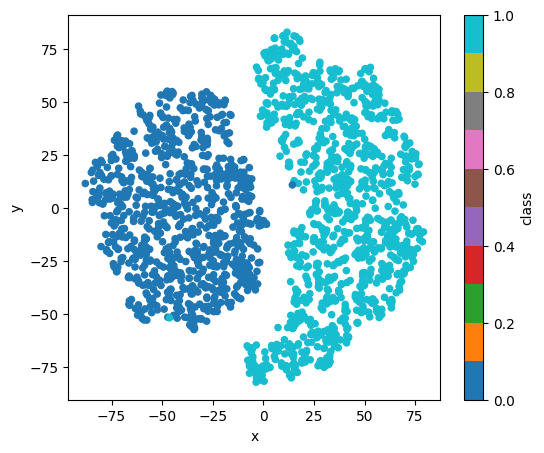

In [91]:
plt.rcParams["figure.figsize"] = [6, 5]
shap_values_2d_df[0:2000].plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)